In [14]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.backend import clear_session
import tensorflow as tf

warnings.simplefilter('ignore')
plt.style.use('fivethirtyeight')

def create_dataset(dataset,look_back=1):
    X,y = [],[]
    for i in range(len(dataset) - look_back):
        features = dataset[i:(i+look_back),0]
        target = dataset[i+look_back,0]
        X.append(features)
        y.append(target)

    return np.array(X), np.array(y)

#### Read Data

In [15]:
data_dir = Path('../data')

df = pd.read_csv(
    data_dir / 'SPP_MSFT.csv',
    usecols=['DNCP','MPN5P']
)

df['DATE'] = pd.to_datetime(df['DNCP'], origin='1899-12-30', unit='D')
df = df.drop('DNCP',axis=1)
df = df.set_index('DATE')

df.head()

,MPN5P
DATE,
2000-02-29,46.765625
2000-03-01,47.070312
2000-03-02,47.656250
2000-03-03,48.000000
2000-03-06,48.750000


#### Prepare the Dataset for LSTM

In [16]:
dataset = df.values
dataset = dataset.astype('float32')

#normalize
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

# train test split
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train,test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# create windowed train test sets
look_back = 60
X_train, y_train = create_dataset(train, look_back=look_back)
X_test, y_test = create_dataset(test, look_back=look_back)

#reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(3877, 60, 1) (1880, 60, 1)
(3877,) (1880,)


#### Define the Model

In [16]:
model = Sequential([
    LSTM(64, return_sequences=True,input_shape=(X_train.shape[1],1)),
    LSTM(64),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 52,191
Trainable params: 52,191
Non-trainable params: 0
_________________________________________________________________


In [9]:
# get inital weights
init_weights = model.get_weights()

In [17]:
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.losses import Huber

lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = SGD(momentum=0.9)
model.compile(loss=Huber(), optimizer=optimizer)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    callbacks=[lr_schedule],
    verbose=2
)

Epoch 1/100
122/122 - 8s - loss: 0.0013 - lr: 1.0000e-08 - 8s/epoch - 67ms/step
Epoch 2/100
122/122 - 1s - loss: 0.0013 - lr: 1.1220e-08 - 756ms/epoch - 6ms/step
Epoch 3/100
122/122 - 1s - loss: 0.0013 - lr: 1.2589e-08 - 710ms/epoch - 6ms/step
Epoch 4/100
122/122 - 1s - loss: 0.0013 - lr: 1.4125e-08 - 711ms/epoch - 6ms/step
Epoch 5/100
122/122 - 1s - loss: 0.0013 - lr: 1.5849e-08 - 706ms/epoch - 6ms/step
Epoch 6/100
122/122 - 1s - loss: 0.0013 - lr: 1.7783e-08 - 708ms/epoch - 6ms/step
Epoch 7/100
122/122 - 1s - loss: 0.0013 - lr: 1.9953e-08 - 706ms/epoch - 6ms/step
Epoch 8/100
122/122 - 1s - loss: 0.0013 - lr: 2.2387e-08 - 699ms/epoch - 6ms/step
Epoch 9/100
122/122 - 1s - loss: 0.0013 - lr: 2.5119e-08 - 702ms/epoch - 6ms/step
Epoch 10/100
122/122 - 1s - loss: 0.0013 - lr: 2.8184e-08 - 708ms/epoch - 6ms/step
Epoch 11/100
122/122 - 1s - loss: 0.0013 - lr: 3.1623e-08 - 722ms/epoch - 6ms/step
Epoch 12/100
122/122 - 1s - loss: 0.0013 - lr: 3.5481e-08 - 722ms/epoch - 6ms/step
Epoch 13/100
12

(0.0001, 0.001, 0.0, 0.02)

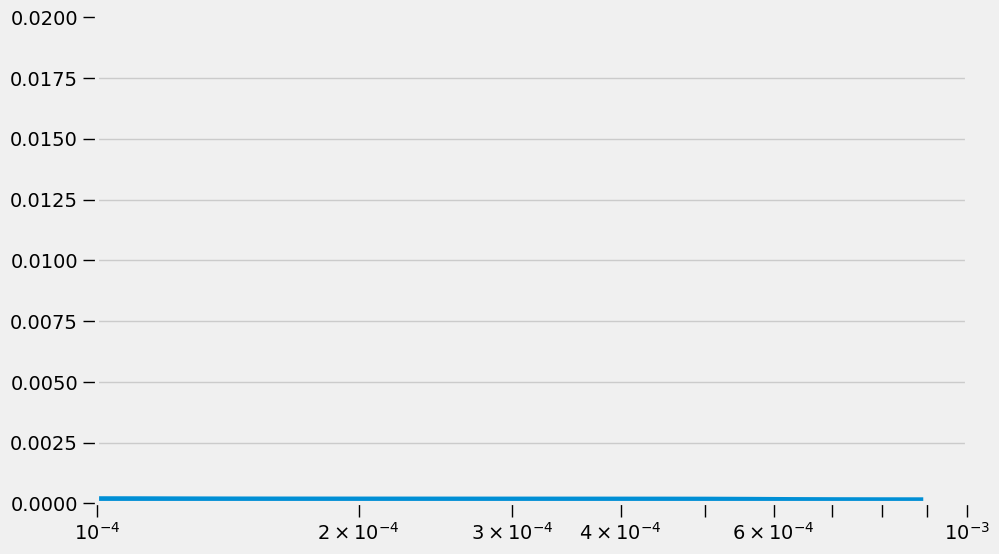

In [18]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-4,1e-3,0,2e-2])

In [19]:
df_hist = pd.DataFrame(history.history)
learning_rate = df_hist[df_hist['loss'] == df_hist['loss'].min()]['lr'].values[0]

print(learning_rate)

0.00089125097


In [20]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [21]:
from keras.metrics import RootMeanSquaredError

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=[RootMeanSquaredError()])

In [22]:
history=model.fit(
    x=X_train,
    y=y_train,
    batch_size=1,
    verbose=2,
    validation_data=(X_test,y_test),
    epochs=50
)

Epoch 1/50
3877/3877 - 32s - loss: 1.4734e-04 - root_mean_squared_error: 0.0172 - val_loss: 0.1443 - val_root_mean_squared_error: 0.5372 - 32s/epoch - 8ms/step
Epoch 2/50
3877/3877 - 27s - loss: 1.2981e-04 - root_mean_squared_error: 0.0161 - val_loss: 0.1454 - val_root_mean_squared_error: 0.5393 - 27s/epoch - 7ms/step
Epoch 3/50
3877/3877 - 28s - loss: 1.2216e-04 - root_mean_squared_error: 0.0156 - val_loss: 0.1456 - val_root_mean_squared_error: 0.5397 - 28s/epoch - 7ms/step
Epoch 4/50
3877/3877 - 27s - loss: 1.1367e-04 - root_mean_squared_error: 0.0151 - val_loss: 0.1465 - val_root_mean_squared_error: 0.5413 - 27s/epoch - 7ms/step
Epoch 5/50
3877/3877 - 27s - loss: 1.0659e-04 - root_mean_squared_error: 0.0146 - val_loss: 0.1463 - val_root_mean_squared_error: 0.5409 - 27s/epoch - 7ms/step
Epoch 6/50
3877/3877 - 27s - loss: 9.9363e-05 - root_mean_squared_error: 0.0141 - val_loss: 0.1479 - val_root_mean_squared_error: 0.5439 - 27s/epoch - 7ms/step
Epoch 7/50
3877/3877 - 27s - loss: 9.142

In [23]:
model.save('raw_features_lstmv2.h5')

#### Load the Model

In [17]:
from keras.models import load_model
model = load_model('../models/raw_features_lstmv2.h5')

#### Evaluate the Model

In [18]:
fitted = model.predict(X_train)
preds = model.predict(X_test)

y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
fitted = scaler.inverse_transform(fitted)
preds = scaler.inverse_transform(preds)

train_rmse = np.sqrt(mean_squared_error(y_train,fitted))
test_rmse = np.sqrt(mean_squared_error(y_test,preds))

print(f'Train rmse: {train_rmse}')
print(f'Test rmse: {test_rmse}')

59/59 [==============================] - 1s 20ms/step
Train rmse: 1.1933075189590454
Test rmse: 131.9678497314453


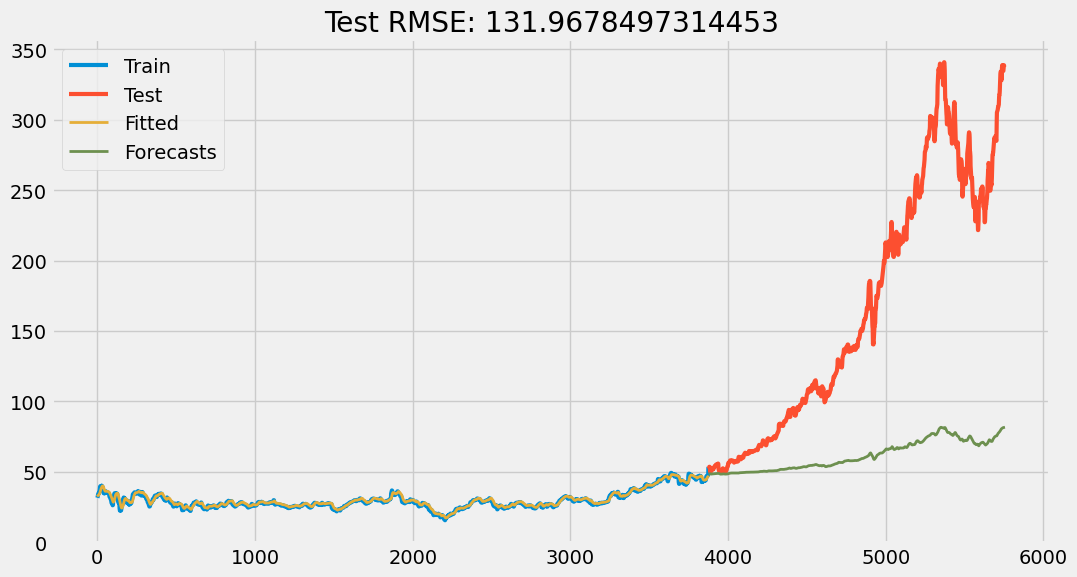

In [19]:
plt.rc("figure", autolayout=True, figsize=(11, 6))
#plt.rc('lines', linewidth=2.5)

y_train_series = pd.Series(y_train.flatten())
y_test_series = pd.Series(y_test.flatten(), index=np.arange(len(y_train), (len(y_train) + len(y_test))))

fitted_series = pd.Series(fitted.flatten(), index=y_train_series.index)
preds_series = pd.Series(preds.flatten(), index=y_test_series.index)

ax = y_train_series.plot(linewidth=3, label='Train')
ax = y_test_series.plot(ax=ax, linewidth=3, label='Test')
ax = fitted_series.plot(ax=ax, linewidth=2, label='Fitted')
_ = preds_series.plot(ax=ax, linewidth=2, label='Forecasts')

plt.title(f'Test RMSE: {mean_squared_error(y_test_series,preds_series,squared=False)}')

plt.legend()